In [2]:
# Do more highly-recommended stocks outperform lowly-rated ones?

import pandas as pd
import numpy as np
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")
import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import sqlite3
from IPython.display import display
from sklearn.metrics import r2_score
import math
pd.set_option('display.max_columns',500)

In [42]:
# Get a list of all SP500 companies
query=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp500 = list(query[0]['Symbol'].values)

In [16]:
def get_history_and_recommendation_data(stock_ticker,period='5y',days_out=180,min_recommendations=5):
    # Prepare yfinance
    print('Results for: '+stock_ticker)
    stock=yf.Ticker(stock_ticker)
    
    # Get historical trading data
    try:
        history=stock.history(period=period)
    except:
        print('No history data for '+stock_ticker)
        return
    
    # Get recommendations
    try:
        recommendations=stock.recommendations.reset_index().sort_values(by=['Firm','Date'])
    except:
        print('No analyst recommendation data for '+stock_ticker)
        return
    recommendations['Next Recommendation']=recommendations.groupby('Firm')['Date'].shift(-1)
    recommendations[str(days_out)+' Days From']=recommendations['Date']+pd.Timedelta(days=days_out)
    recommendations['Good Until']=recommendations\
        [['Next Recommendation',str(days_out)+' Days From']]\
            .min(axis=1) # Define how long a recommendation lasts for - lowest of [days_out] or
                # [Until a new recommendation by that firm]

    # Process the recommendation values
    print('Recommendation values: '\
          +str(sorted(recommendations['To Grade'].dropna().unique()))) # Print out the unique recommendation grades
    assign_values = {'Buy':4, 'Equal-Weight':3, 'Hold':3, 'Market Perform':3, 'Neutral':3,
       'Outperform':4, 'Overweight':4, 'Peer Perform':3, 'Positive':4, 'Reduce':2,
       'Sector Perform':3, 'Sector Weight':3, 'Sell':1, 'Strong Buy':5, 'Strong Sell':1, 'Underperform':1,
       'Underweight':1} # Create numeric representations of the recommendations
    recommendations['Assigned Value']=\
    recommendations['To Grade'].replace(assign_values) # Give the numeric representations a column
    
    # Store the dataframes in sqlite memory
    conn = sqlite3.connect(':memory:')
    history.to_sql('history', conn, index=True)
    recommendations.to_sql('recommendations', conn, index=False)
    
    # Get average analyst assigned scores by day using SQL
    qry = '''
    select h.open, h.high, h.low, h.close, h.volume, date(h.date) as Date, avg(r.'assigned value') as 'Average Assigned Value',
    count(r.'assigned value') as 'Count of Ratings'
    from history h
    left join ( 
    select * from recommendations r 
    where r.firm in 
    (select firm from recommendations group by firm having count(date)>='''+str(int(min_recommendations))+''')
        -- Join recommendations, but only for firms with at least minimum recommendations recommendations
    ) r
    on date(h.date) between date(r.date) and date(r.'good until')
    group by h.open, h.high, h.low, h.close, h.volume, date(h.date)
        '''
    df = pd.read_sql_query(qry, conn).sort_values(by='Date')
    df['Date']=pd.to_datetime(df['Date'])
    return df

In [18]:
aapl=get_history_and_recommendation_data('AAPL')
aapl

Results for: AAPL
Recommendation values: ['', 'Buy', 'Equal-Weight', 'Equal-weight', 'Hold', 'Long-Term Buy', 'Long-term Buy', 'Market Outperform', 'Market Perform', 'Negative', 'Neutral', 'Outperform', 'Overweight', 'Peer Perform', 'Perform', 'Positive', 'Reduce', 'Sector Outperform', 'Sector Perform', 'Sector Weight', 'Sell', 'Strong Buy', 'Underperform', 'Underweight']


,Open,High,Low,Close,Volume,Date,Average Assigned Value,Count of Ratings
0,31.412197,31.586868,31.334303,31.461763,92141600,2017-02-13,3.844444,45
1,31.504256,31.886640,31.452327,31.870119,132904800,2017-02-14,3.844444,45
3,31.988130,32.165160,31.775692,31.985767,142492400,2017-02-15,3.844444,45
4,32.023538,32.077827,31.827625,31.948008,90338400,2017-02-16,3.844444,45
2,31.889007,32.061315,31.889007,32.035351,88792800,2017-02-17,3.844444,45
...,...,...,...,...,...,...,...,...
1237,172.860001,173.949997,170.949997,171.660004,77251200,2022-02-07,3.857143,21
1230,171.729996,175.350006,171.429993,174.830002,74829200,2022-02-08,3.857143,21
1249,176.050003,176.649994,174.899994,176.279999,71285000,2022-02-09,3.857143,21
1239,174.139999,175.479996,171.550003,172.119995,90865900,2022-02-10,3.857143,21


In [52]:
def get_stock_rating_and_return(df,minimum_average_ratings=3,trim_start=100):
    df=df.iloc[100:,:]
    if df['Count of Ratings'].mean() < minimum_average_ratings:
        print('Not enough ratings for this stock.')
        return None, None
    else:
        first_open=df.iloc[[0]]['Open'].values[0]
        last_close=df.iloc[[-1]]['Close'].values[0]
        total_return_fraction=last_close/first_open
        average_rating=df['Average Assigned Value'].mean()
        count_days=df.shape[0]
        return_rate = 100*\
            (total_return_fraction**(1/count_days)-1) # Get the daily 
                            # return rate for the period by taking the n-th root of n-day
                                # cumulative stock movements and subtracting 1 (remember the compound interest equation)
    return return_rate, average_rating

In [55]:
import random
stocks = random.sample(sp500,50)
store_values = []
counter = 1
for stock in stocks:
    print(counter)
    counter += 1
    returns,rating = get_stock_rating_and_return(get_history_and_recommendation_data(stock))
    store_values.append([stock,returns,rating])

Results for: PEG
Recommendation values: ['', 'Buy', 'Equal-Weight', 'Hold', 'In-Line', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Sector Perform', 'Sector Weight', 'Sell', 'Underperform', 'Underweight']
Results for: HAL
Recommendation values: ['', 'Buy', 'Equal-Weight', 'Hold', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Positive', 'Reduce', 'Sector Outperform', 'Sell', 'Strong Buy', 'Underperform', 'Underweight']
Results for: ITW
Recommendation values: ['Buy', 'Cautious', 'Equal-Weight', 'Hold', 'In-Line', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Sector Perform', 'Sell', 'Underperform', 'Underweight']
Results for: ICE
Recommendation values: ['Buy', 'Equal-Weight', 'Hold', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Perform', 'Sector Outperform', 'Sector Perform', 'Strong Buy']
Results for: TFX
Recommendation values: ['Buy', 'Equal-Weight', 'Equal-weight', 'Hold', 'Market Outperform', 'Market Perform', 'Neutral', 'Outperform',

Results for: LH
Recommendation values: ['Buy', 'Hold', 'Market Outperform', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Perform', 'Sector Weight', 'Sell', 'Underperform']
Results for: TMO
Recommendation values: ['Buy', 'Equal-Weight', 'Hold', 'Market Outperform', 'Neutral', 'Outperform', 'Overweight', 'Sector Weight', 'Strong Buy']
Results for: AVGO
Recommendation values: ['', 'Buy', 'Conviction Buy', 'Equal-Weight', 'Hold', 'In-Line', 'Market Outperform', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Positive', 'Top Pick']
Results for: CPRT
Recommendation values: ['Buy', 'Equal-Weight', 'Hold', 'Market Outperform', 'Neutral', 'Outperform', 'Overweight', 'Reduce', 'Underperform', 'Underweight']
Results for: AWK
Recommendation values: ['Buy', 'Equal-Weight', 'Hold', 'Long-Term Buy', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Sell', 'Underperform', 'Underweight']
Results for: CNP
Recommendation values: ['Buy', 'Equal-Weight', 'Hold', 'In-Line', 'M

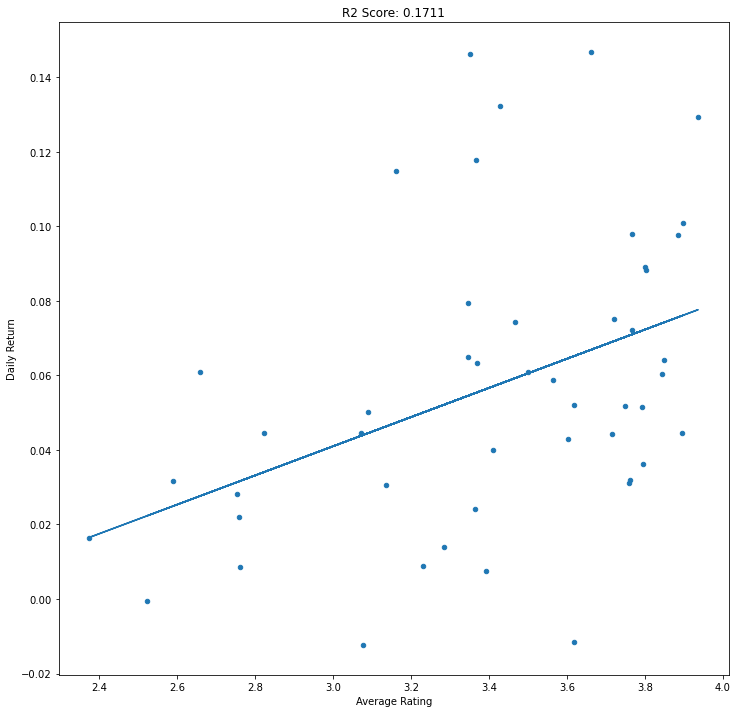

In [59]:
df = pd.DataFrame(store_values,columns=['Ticker','Daily Return','Average Rating']).dropna()
df.plot(x='Average Rating',y='Daily Return',kind='scatter',figsize=(12,12))
m,b = np.polyfit(x=df['Average Rating'],y=df['Daily Return'], deg=1)
plt.plot(df['Average Rating'],df['Average Rating']*m+b)
title = 'R2 Score: '+str(round(r2_score(df['Daily Return'],df['Average Rating']*m+b),4))
plt.title(title)
plt.show()